## GuidedLDA что такое и зачем оно надо
*   Оригинал от автора библиотеки - https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164
*   Репозиторий - https://github.com/vi3k6i5/GuidedLDA
*   Основная работа, которую использовали для создания GuidedLDA - http://www.umiacs.umd.edu/user.php?path=jags/pdfs/GuidedLDA.pdf
* хороший пример использования GuidedLDA - https://github.com/CryptoCompareLTD/research/tree/4bd13b3a8fe7b9d6a891b8d240243695164cd58a/LDA


**Ключевое отличие от LDA**: можно усилить необходимые топики или разделить схожие, если корпус текстов не большой - при инициализации усиливаем какой-либо топик (см. параметр seed_confidence)

In [0]:
! pip install guidedlda
! pip install gensim
! pip install stop_words
! pip install pymystem3
! pip install pymorphy2

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2014-12-rbc.ru.csv to 2014-12-rbc.ru (1).csv
User uploaded file "2014-12-rbc.ru.csv" with length 22864554 bytes


In [3]:
import nltk
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
import guidedlda
import warnings
import stop_words
import matplotlib.pyplot as plt
import pymystem3
import pymorphy2

from pymystem3 import Mystem
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.utils import simple_preprocess
from nltk.tokenize import RegexpTokenizer
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from stop_words import get_stop_words
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

nltk.download('stopwords') 
stemmer = SnowballStemmer('russian')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
data = pd.read_csv('2014-12-rbc.ru.csv', sep=',', encoding='utf-8')
data.columns = ['URL','date','topics','title','text']

In [5]:
data.head()

,URL,date,topics,title,text
0,http://top.rbc.ru/politics/01/12/2014/547bb1f8...,2014-12-01 00:11:32,NaN,ДНР и ЛНР просят заменить украинские банки абх...,До начала вооруженного конфликта в Донбассе ра...
1,http://www.rbc.ru/rbcfreenews/547bb630cbb20f09...,2014-12-01 00:28:34,NaN,Приморские города Крыма получат установки по о...,Приморские города Крыма получат установки по о...
2,http://www.rbc.ru/rbcfreenews/547bbd6dcbb20f53...,2014-12-01 00:59:25,NaN,Швейцарцы проголосовали против наращивания зол...,Граждане Швейцарии не поддержали на прошедшем ...
3,http://top.rbc.ru/economics/01/12/2014/547bc22...,2014-12-01 01:19:44,NaN,Стоимость барреля нефти опустилась ниже 69 дол...,Стоимость барреля нефти опустилась ниже $69\nА...
4,http://www.rbc.ru/rbcfreenews/547bc4bbcbb20fbc...,2014-12-01 01:30:36,NaN,На северо-востоке Подмосковья в ДТП погибли че...,На северо-востоке Подмосковья в дорожно-трансп...


In [0]:
def clean_text(text, russian_words_only: bool = False, remove_stop: bool = True):

    text = str(text).lower()
    if russian_words_only:
        text = re.sub("[^а-я]", ' ', str(text))
        text = text.strip()

    else:
        text = re.sub('-\s\r\n\|-\s\r\n|\r\n|[«»]|[""]|[><]"[\[]]|//"', '', text)
        text = re.sub('[«»]|[""]|[><]"[\[]]"', '', text)
        text = re.sub('[0-9]|[-.,:;_%©?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|"|–|—|', ' ', text)
        text = re.sub(r'\r\n\t|\n|\\s|\r\t|\\n', ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text)
        text = re.sub('ё', 'е', text.strip())

    if remove_stop:
        text = remove_stopwords(text)

    return text

def remove_stopwords(text):
    stopword_ru = stopwords.words('russian')
    stopword_ru.append('м')
    stopword_ru.append('это')
    stopword_ru.append('по')
    stopword_ru.append('также')
    

    text = [w for w in text.split() if w not in stopword_ru]

    return text

In [0]:
 def normalize(text : list, simple_tokenize: bool = False, return_tokenized: bool = False, lemma = 'pymorphy'):
        if simple_tokenize:
            words = text.split()
        else:
            words = text
        #print(words)
        if lemma == 'nltk':
            lemmatizer = WordNetLemmatizer()
            lemmatized = [lemmatizer.lemmatize(w) for w in words]
        elif lemma == 'pymorphy':
            morph = pymorphy2.MorphAnalyzer()
            lemmatized = [morph.parse(w)[0].normal_form for w in words]
        elif lemma == 'mystem':
            mystem = Mystem()
            lemmatized = mystem.lemmatize(words)
        #print(lemmatized)
        if not return_tokenized:
            return ' '.join(lemmatized)
        else:
            return lemmatized

In [8]:
%%time
data['cleaned_text'] = data['text'].apply(clean_text)
data['token_text'] = data['cleaned_text'].apply(lambda x: normalize(x, simple_tokenize=False, return_tokenized=True))

CPU times: user 10min 59s, sys: 35.9 s, total: 11min 35s
Wall time: 11min 35s


In [16]:
data[['date','title','text','cleaned_text','token_text']].head()

,date,title,text,cleaned_text,token_text
0,2014-12-01 00:11:32,ДНР и ЛНР просят заменить украинские банки абх...,До начала вооруженного конфликта в Донбассе ра...,"[начала, вооруженного, конфликта, донбассе, ра...","[начало, вооружённый, конфликт, донбасс, работ..."
1,2014-12-01 00:28:34,Приморские города Крыма получат установки по о...,Приморские города Крыма получат установки по о...,"[приморские, города, крыма, получат, установки...","[приморский, город, крым, получить, установка,..."
2,2014-12-01 00:59:25,Швейцарцы проголосовали против наращивания зол...,Граждане Швейцарии не поддержали на прошедшем ...,"[граждане, швейцарии, поддержали, прошедшем, р...","[гражданин, швейцария, поддержать, прошедшее, ..."
3,2014-12-01 01:19:44,Стоимость барреля нефти опустилась ниже 69 дол...,Стоимость барреля нефти опустилась ниже $69\nА...,"[стоимость, барреля, нефти, опустилась, ниже, ...","[стоимость, баррель, нефть, опуститься, ниже, ..."
4,2014-12-01 01:30:36,На северо-востоке Подмосковья в ДТП погибли че...,На северо-востоке Подмосковья в дорожно-трансп...,"[северо, востоке, подмосковья, дорожно, трансп...","[северо, восток, подмосковье, дорожный, трансп..."


### Готовим Doc-term матрицу

In [17]:
processed_docs = data['token_text']
dictionary = gensim.corpora.Dictionary(processed_docs)

def bow_iterator(docs, dictionary):
    for doc in docs:
        yield dictionary.doc2bow(doc)

def get_term_matrix(docs, dictionary):
    bow = bow_iterator(docs, dictionary)
    X = np.transpose(matutils.corpus2csc(bow).astype(np.int64))
    return X

doc_term_matrix = get_term_matrix(processed_docs, dictionary)
vocab = tuple(dictionary.values())
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(doc_term_matrix.toarray())

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(40108 unique tokens: ['абхазия', 'абхазский', 'агрба', 'адгур', 'аналитический']...) from 7076 documents (total 1162165 corpus positions)


[[1 3 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]]


### GuidedLDA без выделения топиков

In [60]:
model = guidedlda.GuidedLDA(n_topics=22, n_iter=100, random_state=7, refresh=10)
model.fit(doc_term_matrix)

INFO:guidedlda:n_documents: 7076
INFO:guidedlda:vocab_size: 40108
INFO:guidedlda:n_words: 1162165
INFO:guidedlda:n_topics: 22
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -14819983
INFO:guidedlda:<10> log likelihood: -10808517
INFO:guidedlda:<20> log likelihood: -10299376
INFO:guidedlda:<30> log likelihood: -10108151
INFO:guidedlda:<40> log likelihood: -9994074
INFO:guidedlda:<50> log likelihood: -9922393
INFO:guidedlda:<60> log likelihood: -9871123
INFO:guidedlda:<70> log likelihood: -9829612
INFO:guidedlda:<80> log likelihood: -9797335
INFO:guidedlda:<90> log likelihood: -9771848
INFO:guidedlda:<99> log likelihood: -9755491


In [61]:
topic_word = model.topic_word_
n_top_words = 15

for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: боевик человек дом грозный здание который кадыров чечня глава декабрь центр сотрудник сообщить один город
Topic 1: год россия украина миллиард поставка российский правительство министр компания миллион декабрь том который роснефть тысяча
Topic 2: матч лига команда чемпионат зенит спартак чемпион цска игра который тренер европа динамо играть один
Topic 3: матч чемпионат голый тур счёт победа й гол минута мяч реал команда испания врезка кхл
Topic 4: год компания рубль миллион рбк продажа рынок миллиард тысяча цена один который директор говорить сеть
Topic 5: автомобиль машина год фильм тысяча который дилер декабрь сообщить человек сообщать sony атака произойти модель
Topic 6: россия мир год кубок этап место стать гонка сборный чемпионат хороший сборная команда два российский
Topic 7: клуб команда игрок год контракт официальный спорт тренер футболист сообщать зарплата сборный матч сезон который
Topic 8: который год бой футбол матч рфс спорт чемпионат стадион мир слово свой болель

Видно, что выделяются топики про украину - 11, отдельно российский и иностранный футбол - 2, 8 и 3, 17; и общий футбол - 7,  хоккей - 13 (нхл).
Также выделились топики про навального, южный поток, итоги года (т.к. датасет декабрьский). 21 топик непонятно про что.

### GuidedLDA с выделением топиков
Разделим отдельно футбол российский и иностранный, кхл и нхл, навального, евтушенко - во внутреннюю политику, разделим банки и экономику, аналогично разделим нефть и госкорпорации. Оставим 3 свободные темы, чтобы не перебивались выделенные темы.

In [0]:
seed_topics_list_glda = [['украина', 'донецк','луганск', 'порошенко', 'яценюк', 'киев', 'конфликт','донбасс','переговоры', 'санкция', 'крым', 'отношение'],
    ['биатлон', 'волейбол', 'тренер', 'команда', 'баскетбол', 'нба', 'гимнастика','биатлон'],
    ['нато', 'оон', 'евросоюз', 'рф', 'сша', 'китай', 'европарламент','ес', 'террорист','мид', 'иммигрант'],
                    ['газпром', 'нефть', 'роснефть', 'добыча', 'запас', 'газ', 'трубопровод', 'поток'],
               ['полиция', 'митинг', 'область', 'регион', 'губернатор',
                'выборы','дума','дорога','повестка','прокуратура','указ', 'законопроект', 'навальный','башнефть','евтушенко', 'система'],
               ['google', 'apple','microsoft', 'гейтс', 'маск', 'tesla', 'интернет', 'портал', 'вконтакте','дуров', 'mail'],
                    ['рубль', 'курс', 'евро','юань','доллар', 'банк', 'стагнация', 'дефолт', 'риск', 'индекс'],
                    ['матч', 'чемпионат', 'клуб' ,'год','тур', 'команда', 'реал', 'лига', 'сезон', 'футболист', 'манчестер', 'челси', 'гол', 'чемпион', 'барселона',
                    'месси'],
                    ['россия', 'санкция', 'сша', 'президент','крым'],
                    ['дума','председатель', 'депутат', 'заседание', 'чтение', 'законопроект', 'спикер', 'большинство','госдума'],
                    ['полиция', 'следователь', 'дело', 'расследование', 'задержание', 'суд', 'срок'],
                    ['авария', 'катастрофа', 'бедствие', 'трагедия', 'масштаб', 'ураган', 'торнадо', 'наводнение', 'паводок'],
                    ['корпорация', 'роскосмос', 'оак', 'оск', 'роснефть', 'сбербанк', 'втб'],
                    ['банк', 'ставка', 'кредит','вклад', 'ипотека', 'цб'],
                    ['партия', 'выборы', 'агитация', 'кандидат', 'меньшинство', 'порог', 'коммунист', 'либерал', 'правый', 'левый', 'фронт', 'националист'],
                    ['оскар', 'сбор', 'премия', 'касса', 'бюджет', 'актриса', 'сценарий', 'награда', 'постановка'],
                    ['футбол', 'уефа', 'фифа', 'мяч', 'рфс', 'кубок', 'лига', 'чемпион', 'матч', 'команда', 'чемпионат', 'лига', 'игра', 'тур', 'зенит', 'победа', 'цска',
                     'гол', 'чемпион'],
                    ['матч', 'нхл', 'очки', 'подбор', 'стэнли', 'кубок', 'регулярный', 'передача', 'шайба', 'звезда', 'кросби', 'овечкин', 'малкин'],
                    ['россия', 'чемпионат', 'кхл', 'матч', 'сочи', 'команда', 'олимпийский', 'регулярный'],
                    
                   ]

topic_names_lgda = ['Украина', 'Спорт', 'Мировая политика', 'Нефть',
               'Внутренняя политика', 'Tech_Интернет', 'Экономика', 'Иностранный футбол',
               'Санкции', 'Госдума', 'Полиция, расследования', 'Аварии', 'Госкорпорации',
               'Банки','Партии и выборы', 'Фильмы и кино', 'Российский Футбол','НХЛ', 'КХЛ',
                    'Свободная','Свободная2', 'Свободная3'
                   ]

n_topics_glda = len(topic_names_lgda)

In [87]:
%%time
model1 = guidedlda.GuidedLDA(n_topics=n_topics_glda, n_iter=100,random_state=17, refresh=20)

CPU times: user 2.39 ms, sys: 798 µs, total: 3.19 ms
Wall time: 6.4 ms


In [0]:
seed_topics_glda = {}

for t_id, st in enumerate(seed_topics_list_glda):
  for word in st:
    try:
      seed_topics_glda[word2id[word]] = t_id
    except:
      print(f'не найдено слово {word}')
      seed_topics_list_glda[t_id].remove(word)
      pass

In [89]:
%%time
model1.fit(doc_term_matrix, seed_topics=seed_topics_glda, seed_confidence=0.15)

INFO:guidedlda:n_documents: 7076
INFO:guidedlda:vocab_size: 40108
INFO:guidedlda:n_words: 1162165
INFO:guidedlda:n_topics: 22
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -14799086
INFO:guidedlda:<20> log likelihood: -10085679
INFO:guidedlda:<40> log likelihood: -9879025
INFO:guidedlda:<60> log likelihood: -9799133
INFO:guidedlda:<80> log likelihood: -9753391
INFO:guidedlda:<99> log likelihood: -9728459


CPU times: user 29.2 s, sys: 74.1 ms, total: 29.3 s
Wall time: 29.3 s


In [90]:
topic_word_glda = model1.topic_word_
n_top_words = 15

for topic_id, topic in enumerate(model1.topic_word_):
  print(f"Topic {topic_names_lgda[topic_id]}:")
  topic_words = np.array(vocab)[np.argsort(topic)][:-(n_top_words+1):-1]
  print(" ".join(topic_words))

Topic Украина:
украина украинский декабрь россия переговоры крым представитель киев заявить сторона сообщить порошенко республика донбасс который
Topic Спорт:
россия мир год спорт который российский этап один спортсмен хороший олимпийский кубок стать очень тренер
Topic Мировая политика:
россия российский санкция страна ес который год европейский заявить поставка против крым евросоюз решение президент
Topic Нефть:
год нефть цена компания миллиард проект газпром роснефть страна южный поток газа поставка миллион добыча
Topic Внутренняя политика:
компания акция год суд система башнефть миллион миллиард который иск решение рубль евтушенков афк рбк
Topic Tech_Интернет:
компания сайт сервис пользователь который тысяча интернет год миллион яндекс модель магазин представитель карта приложение
Topic Экономика:
рубль цена курс рынок доллар год валюта декабрь евро уровень валютный россия цб рост торг
Topic Иностранный футбол:
клуб год команда тренер чемпионат спорт игрок футболист официальный спар

### Итоги

*   Топики "Партия и выборы", "Фильмы и кино" выделить не получилось (ключевые слова неоднозначные).

*   Навальный все-таки попадает в топик "Полиция, расследование". 

*   "Свободная" - тема про продуктовые сети или рынки

*   "Свободна2" - тема про рынок автомобилей, скорее всего. 

*   "Свободная3" - набор лозунгов

*  Топики "Санкции" и "Мировая политика" - трудно разделяются

### Посмотрим распределение документов по топикам и наиболее вероятный топик для каждого документа

In [0]:
doc_topic = model1.transform(doc_term_matrix)

In [73]:
highest_topic = []
for i in range(len(doc_topic)):
    match = doc_topic[i].argmax()
    highest_topic.append(match)
len(highest_topic)

7076

In [74]:
HT = pd.DataFrame(highest_topic, columns = ['HighTopicIndex'])
lookuptable = pd.DataFrame(topic_names_lgda, columns = ['topic'])
lookuptable['HighTopicIndex'] = lookuptable.index
prep2 = pd.merge(HT, lookuptable, on = 'HighTopicIndex', how = 'left')
prep = pd.concat([data, prep2], axis = 1)
prep[['date','text','HighTopicIndex','topic']].head(10)

,date,text,HighTopicIndex,topic
0,2014-12-01 00:11:32,До начала вооруженного конфликта в Донбассе ра...,0,Украина
1,2014-12-01 00:28:34,Приморские города Крыма получат установки по о...,0,Украина
2,2014-12-01 00:59:25,Граждане Швейцарии не поддержали на прошедшем ...,2,Мировая политика
3,2014-12-01 01:19:44,Стоимость барреля нефти опустилась ниже $69\nА...,6,Экономика
4,2014-12-01 01:30:36,На северо-востоке Подмосковья в дорожно-трансп...,15,Фильмы и кино
5,2014-12-01 01:57:04,"В СКР утверждают, что причиной преступления ст...",4,Внутренняя политика
6,2014-12-01 02:24:03,На итоги парламентских выборов в Молдавии могл...,14,Партии и выборы
7,2014-12-01 02:51:05,"Социалистическая партия, занимающая первое мес...",14,Партии и выборы
8,2014-12-01 02:59:15,Российскую спутниковую группировку пополнил вт...,21,Свободная3
9,2014-12-01 03:18:54,Член комитета по транспорту Государственной ду...,14,Партии и выборы


## Немного визуализации

In [0]:
def display_assignment(model, topic_names):
        assignments = [sum(m) for m in model.doc_topic_.T]
        plt.pie(assignments, labels = topic_names)
        plt.show()

In [0]:
def example_documents(data, model, topic_name, threshold= 0.7):
  """
  Документы, относящие сильнее всего к топику  
  """
  topic = topic_names_lgda.index(topic_name)
  docs = []
  print("Топик: {}".format(topic_name))
  for i, doc_dist in enumerate(model.doc_topic_):
    if doc_dist[topic]>0.7:
      #print('1')
      docs.append(data.text[i])
  for doc in docs:
    print(doc + '\n')

In [0]:
def separate_date(timestamp):
    return pd.to_datetime(timestamp)

### Возьмем только основные топики для документов

In [0]:
thresh = 0.1 
def define_allocation(allocation):
    if allocation < thresh:
        return 0
    else:
        return allocation

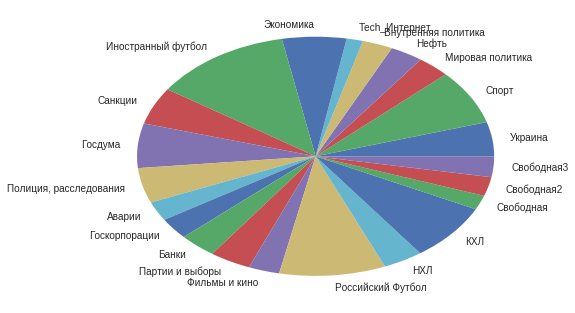

In [104]:
display_assignment(model1, topic_names_lgda)

In [105]:
example_documents(data, model1, 'Иностранный футбол', threshold=0.1)

Топик: Иностранный футбол
Павленко: Дзюба – нападающий номер один в России
Бывший игрок «Спартака», Александр Павленко поделился мнением о ситуации с контрактом форварда красно-белых Артема Дзюбы.
– Федун сказал: «Дзюба хочет получать, как Халк».
– А я считаю, правильно. Дзюба – нападающий номер один в России. Почему сразу пишут: «Да че он там выиграл, где поиграл?!» Лучший бомбардир чемпионата, что еще нужно? Как еще посчитать его уровень игры?
Прошлый сезон провел в «Ростове» – лучший бомбардир. Федун говорит, что он не Халк. Ну как не Халк, если делает свое дело, забивает голы? Вы хотите этого футболиста, он хочет такие деньги – сделайте. Лично я на стороне Дзюбы», - цитирует Павленко еженедельник «Футбол».

КДК не усмотрел дисциплинарного нарушения в словах Якина. Видео
Глава КДК РФС Артур Григорьянц заявил, что его ведомство не собирается рассматривать интервью главного тренера «Спартака» Мурата Якина в эфире телеканала «Наш футбол».
На вопрос журналиста Тимура Журавеля швейцарски

In [0]:
# Смотрим распределение топиков по дате публикации
df = prep[['topic', 'date']]


df_allocations = pd.DataFrame(model1.doc_topic_, columns = topic_names_lgda) 
df = pd.concat([df, df_allocations], axis=1)

df['date'] = df['date'].apply(separate_date)
for name in topic_names_lgda:
    df[name] = df[name].apply(define_allocation)
    
df_publications = df.groupby('date').sum().groupby(pd.Grouper(freq='1d')).sum()

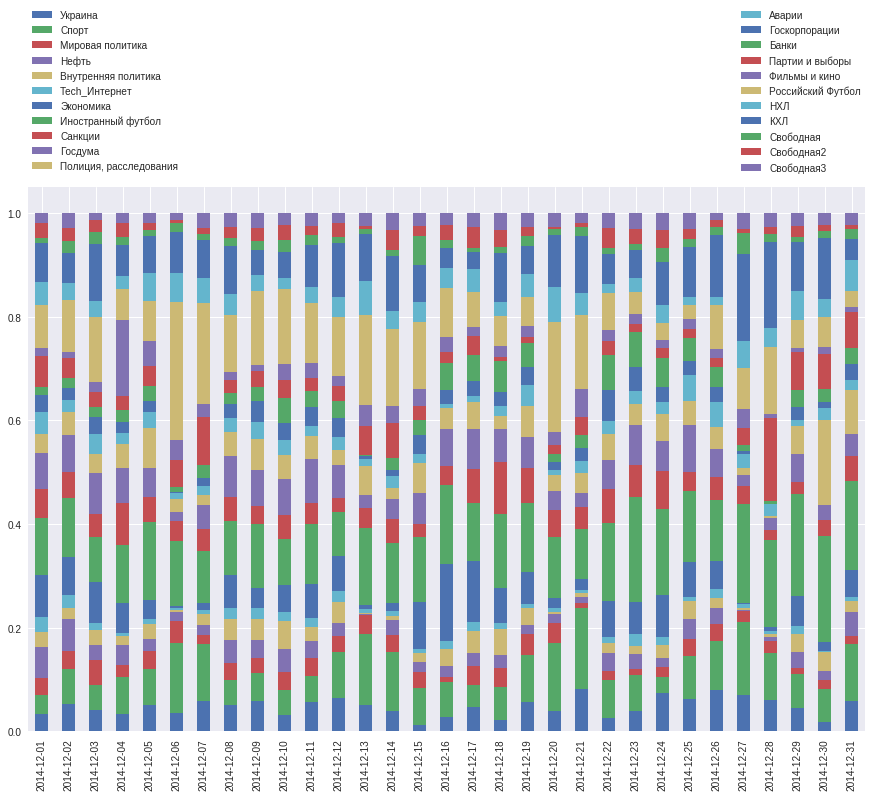

In [107]:
fig, ax = plt.subplots(figsize = (15, 10))
df_publications.divide(df_publications.sum(axis=1), axis=0).plot(kind='bar', stacked=True, ax=ax)
legend = ax.legend(loc='upper center', shadow=True)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_xticklabels(df_publications.index.strftime("%Y-%m-%d"))
ax.set_xlabel("");

In [0]:
%%time
doc_term_matrix_p = [dictionary.doc2bow(doc) for doc in data['token_text'].values]
ldamodel = LdaModel(doc_term_matrix_p, num_topics=22, id2word = dictionary, passes=10)

In [0]:
%%time
perplexity = ldamodel.log_perplexity(doc_term_matrix_p)
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data['token_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [110]:
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.0500940890353
Coherence Score: 0.5583640813796171
